In [1]:
from bs4 import BeautifulSoup
import re
import requests
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# declare header to make sure imdb allows us to scrape
headers = {'user-agent':'Mozilla/5.0 \
            (Windows NT 10.0; Win64; x64) \
            AppleWebKit/537.36 (KHTML, like Gecko) \
            Chrome/84.0.4147.105 Safari/537.36'}

In [3]:
# get soup of the page
url = 'https://www.imdb.com/chart/top/'
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

In [4]:
# get the specific list we want
script_tag = soup.find('script', {'type': 'application/ld+json'})
# and convert it into a string, then split into a list of each item
movieList = script_tag.string.split("},{")

In [5]:
movieList[0]

'{"@type":"ItemList","itemListElement":[{"@type":"ListItem","item":{"@type":"Movie","url":"https://www.imdb.com/title/tt0111161/","name":"The Shawshank Redemption","description":"A banker convicted of uxoricide forms a friendship over a quarter century with a hardened convict, while maintaining his innocence and trying to remain hopeful through simple compassion.","image":"https://m.media-amazon.com/images/M/MV5BMDAyY2FhYjctNDc5OS00MDNlLThiMGUtY2UxYWVkNGY2ZjljXkEyXkFqcGc@._V1_.jpg","aggregateRating":{"@type":"AggregateRating","bestRating":10,"worstRating":1,"ratingValue":9.3,"ratingCount":3075886},"contentRating":"14A","genre":"Drama","duration":"PT2H22M"}'

In [6]:
## Patterns that we are looking for
# pattern for the title
titlePat = r'ame(?!.*alternateName)\":\".*?,\"description'
# pattern for the description
descPat = r'description\":\".*?,\"image'
# pattern for rating value
ratePat = r'ratingValue\":[1234567890.]+'
# pattern for rating count
rateCountPat = r'ratingCount\":[1234567890]+'
# pattern for genre
genrePat = r'genre\":.*,\"duration"'
# pattern for duration
durPat = r'\"PT[0123456789].*?\"'



movies = []

for movie in movieList:
    # title finding
    title = re.search(titlePat, movie).group()[6:-14]
    # description finding
    desc = re.search(descPat, movie).group()[14:-8]
    # rating finding
    rate = float(re.search(ratePat, movie).group()[13:])
    rateCount = int(re.search(rateCountPat, movie).group()[13:])
    # genre finding
    genre = re.search(genrePat, movie).group()[8:-12]
    genre = genre.split(", ")
    # duration finding
    duration = 0
    dur = re.search(durPat, movie).group()
    minutes = re.search(r'[0123456789]+M', dur)
    if minutes:
        duration += int(minutes.group()[:-1])
    hours = re.search(r'[0123456789]+H', dur)
    if hours:
        duration += 60 * int(hours.group()[:-1])
        
    data = {
        "Title": title,
        "Description": desc,
        "Rating": rate,
        "Rating Count": rateCount,
        "Duration": duration,
        "Genre": genre
    }
    movies.append(data)

In [7]:
df = pd.DataFrame(movies)
## Get a list of all unique genres (sorted alphabetically)
allGenres = sorted(list(set(genre for movieGenre in df['Genre'] for genre in movieGenre)))
# now make boolean columns representing those genres
for genre in allGenres:
    df[genre] = df['Genre'].apply(lambda genreList: genre in genreList)

In [8]:
df

,Title,Description,Rating,Rating Count,Duration,Genre,Action,Adventure,Animation,Biography,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,The Shawshank Redemption,A banker convicted of uxoricide forms a friend...,9.3,3075886,142,[Drama],False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,The Godfather,The aging patriarch of an organized crime dyna...,9.2,2145535,175,"[Crime, Drama]",False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,The Dark Knight,When a menace known as the Joker wreaks havoc ...,9.1,3050157,152,"[Action, Crime, Drama]",True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,The Godfather Part II,The early life and career of Vito Corleone in ...,9.0,1443134,202,"[Crime, Drama]",False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,12 Angry Men,The jury in a New York City murder trial is fr...,9.0,939321,96,"[Crime, Drama]",False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,Groundhog Day,"A narcissistic, self-centered weatherman finds...",8.0,721693,101,"[Comedy, Drama, Fantasy]",False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
246,The Help,An aspiring author during the civil rights mov...,8.1,516570,146,[Drama],False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
247,Gangs of Wasseypur,A clash between Sultan and Shahid Khan leads t...,8.2,109098,321,"[Action, Comedy, Crime]",True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
248,Drishyam,Desperate measures are taken by a man who trie...,8.2,102835,163,"[Crime, Drama, Mystery]",False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [9]:
df['Rating Count']

0      3075886
1      2145535
2      3050157
3      1443134
4       939321
        ...   
245     721693
246     516570
247     109098
248     102835
249      86771
Name: Rating Count, Length: 250, dtype: int64

Text(0.5, 1.0, 'Distribution of Runtime (in minutes) of Top 250 Movies on IMDb')

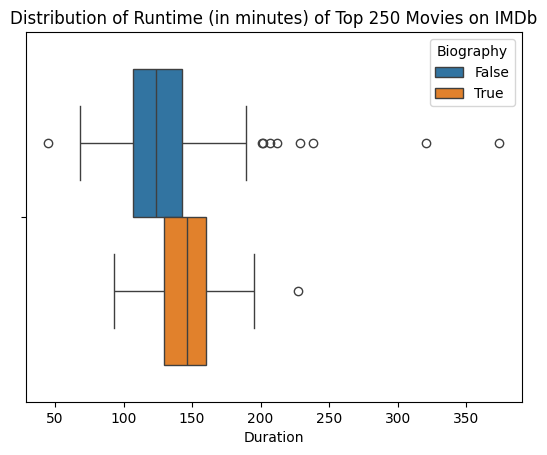

In [10]:
sns.boxplot(data=df, x='Duration', hue='Biography')
plt.title("Distribution of Runtime (in minutes) of Top 250 Movies on IMDb")

Text(0.5, 1.0, 'Distribution of Ratings for Top 250 Movies on IMDb')

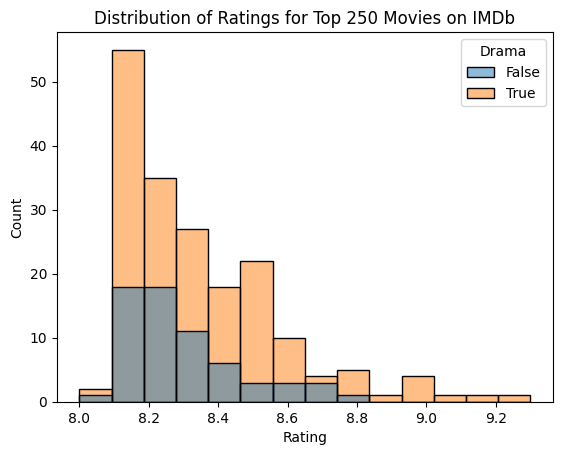

In [11]:
sns.histplot(data=df, x='Rating', hue='Drama')
plt.title("Distribution of Ratings for Top 250 Movies on IMDb")

In [44]:
ratingCount = []
for genre in (df.columns.tolist()[6:]):
    avgRatingCount = int(df[df[genre] == True]['Rating Count'].mean())
    data = {
        "Genre": genre,
        "Avg Rating Count": avgRatingCount
    }
    ratingCount.append(data)

rCdf = pd.DataFrame(ratingCount)
rCdf = rCdf.sort_values('Avg Rating Count', ascending=False)

<Axes: xlabel='Avg Rating Count', ylabel='Genre'>

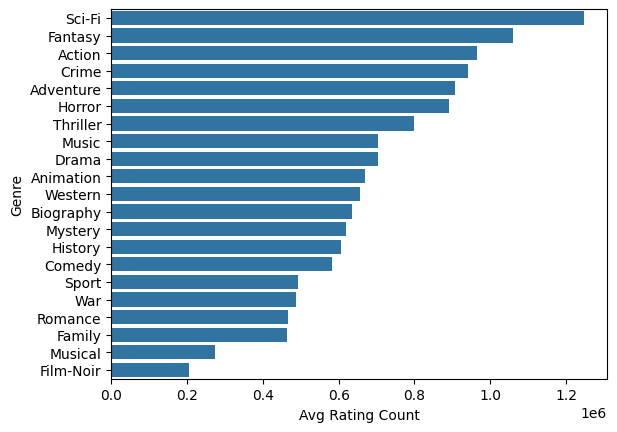

In [46]:
sns.barplot(data=rCdf, x='Avg Rating Count', y='Genre')

Here we see that Sci-Fi films get more ratings on average than other genres, and Film-Noirs get the lowest number of ratings on average. This is likely due to the fact that Film-Noir films only were made prior to the existence of IMDb. On the other hand, great Sci-Fi films were only released more recently.